In [81]:
# System and data handling
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# EDF and XML processing
import pyedflib
import xml.etree.ElementTree as ET

# Preprocessing and training tools
from sklearn.model_selection import train_test_split
from sklearn.utils import resample as sklearn_resample

# Deep Learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Define file paths
This cell lists all EDFs and checks if each has a matching annotation file. It builds a dictionary of valid pairs to process later.

In [82]:
# Define folders
EDF_FOLDER = 'edf_data/'
ANNOT_FOLDER = 'annotations/'

# Get sorted list of available EDF and XML files
edf_files = sorted([f for f in os.listdir(EDF_FOLDER) if f.endswith('.edf')])
xml_files = sorted([f for f in os.listdir(ANNOT_FOLDER) if f.endswith('.xml')])

# Extract unique IDs from EDF filenames
edf_ids = {f.split('-')[1].split('.')[0] for f in edf_files}

# Match EDFs with corresponding XML annotations
edf_xml_pairs = [
    (os.path.join(EDF_FOLDER, f"shhs2-{id}.edf"),
     os.path.join(ANNOT_FOLDER, f"shhs2-{id}-nsrr.xml"))
    for id in edf_ids if f"shhs2-{id}-nsrr.xml" in xml_files
]

print(f"Matched {len(edf_xml_pairs)} EDF/XML pairs.")


Matched 504 EDF/XML pairs.


### Define Signal Extraction Function
This function:

Reads an EDF file

Extracts:

SaO2 (SpO₂) – 1 Hz

PR (Heart Rate) – 1 Hz

THOR RES (Thoracic) – 8 Hz → downsampled to 1 Hz

ABDO RES (Abdominal) – 8 Hz → downsampled to 1 Hz

Returns all 4 signals as a 2D NumPy array with shape [duration_in_sec, 4]

### Extract Apnea Event Intervals from XML
This function:

Loads the XML file using ElementTree

Looks for <ScoredEvent> entries with event type "Apnea"

Collects (start_time, duration) pairs

Returns a list of apnea intervals in seconds

In [83]:
def extract_signals_from_edf(edf_path):
    with pyedflib.EdfReader(edf_path) as f:
        label_map = {label.upper(): i for i, label in enumerate(f.getSignalLabels())}

        required_channels = {
            'SpO2': 'SAO2',
            'HR': 'PR',
            'Thoracic': 'THOR RES',
            'Abdominal': 'ABDO RES'
        }

        # Check if all required channels are present
        for ch in required_channels.values():
            if ch not in label_map:
                print(f"Missing channel {ch} in {edf_path}")
                return None

        # Load signals
        sao2 = f.readSignal(label_map['SAO2'])
        hr = f.readSignal(label_map['PR'])
        thor = f.readSignal(label_map['THOR RES'])
        abdo = f.readSignal(label_map['ABDO RES'])

        # Downsample Thoracic and Abdominal from 8Hz to 1Hz
        factor = 8
        thor_ds = thor[::factor]
        abdo_ds = abdo[::factor]

        # Ensure same length
        min_len = min(len(sao2), len(hr), len(thor_ds), len(abdo_ds))
        signals = np.stack([
            sao2[:min_len],
            hr[:min_len],
            thor_ds[:min_len],
            abdo_ds[:min_len]
        ], axis=1)

        # ✅ Normalize each channel independently
        min_vals = np.min(signals, axis=0)
        max_vals = np.max(signals, axis=0)
        signals = (signals - min_vals) / (max_vals - min_vals + 1e-8)

        return signals


### Segment Signals into 60-Second Windows with Labels

This function:

Takes the [n_seconds, 4] signal array and apnea intervals

Slides a 60-second window (no overlap)

Labels each window based on overlap with apnea events

python
Copy
Edit


In [84]:
def create_windows_and_labels(signal_array, apnea_intervals, window_size=60):
    num_windows = signal_array.shape[0] // window_size
    X, y = [], []

    for i in range(num_windows):
        start_sec = i * window_size
        end_sec = start_sec + window_size

        window = signal_array[start_sec:end_sec]
        if window.shape[0] < window_size:
            continue  # Skip incomplete window

        # Check for overlap with apnea
        label = 0
        for apnea_start, apnea_end in apnea_intervals:
            if apnea_start < end_sec and apnea_end > start_sec:
                label = 1
                break

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


In [85]:
def extract_apnea_intervals(xml_path):
    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_path)
    root = tree.getroot()

    apnea_intervals = []

    for event in root.findall(".//ScoredEvent"):
        concept_elem = event.find("EventConcept")

        if concept_elem is None:
            continue

        concept = concept_elem.text.strip().lower()

        # Match any kind of apnea or hypopnea event
        if "apnea" in concept or "hypopnea" in concept:
            try:
                start = float(event.find("Start").text)
                duration = float(event.find("Duration").text)
                apnea_intervals.append((start, start + duration))
            except:
                continue

    return apnea_intervals


### Build the Full Dataset from All Files

This cell loops over all matched pairs:

Extracts signal data

Extracts apnea intervals

Generates windowed samples and labels

Combines everything into full X and y arrays

In [86]:
X_all, y_all = [], []

for edf_path, xml_path in edf_xml_pairs:
    print(f"Processing: {os.path.basename(edf_path)}")

    signals = extract_signals_from_edf(edf_path)
    if signals is None:
        continue

    apnea_intervals = extract_apnea_intervals(xml_path)

    X, y = create_windows_and_labels(signals, apnea_intervals)

    if len(X) == 0:
        continue

    X_all.append(X)
    y_all.append(y)

# Stack
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print(f"Final dataset shape: X = {X_all.shape}, y = {y_all.shape}")
print(f"Class distribution: {np.bincount(y_all)}")


Processing: shhs2-201099.edf
Processing: shhs2-200693.edf
Processing: shhs2-200923.edf
Processing: shhs2-200699.edf
Processing: shhs2-200984.edf
Processing: shhs2-201086.edf
Processing: shhs2-200753.edf
Processing: shhs2-200437.edf
Processing: shhs2-200078.edf
Processing: shhs2-200908.edf
Processing: shhs2-200577.edf
Processing: shhs2-200661.edf
Processing: shhs2-200752.edf
Processing: shhs2-201207.edf
Processing: shhs2-200962.edf
Processing: shhs2-200696.edf
Processing: shhs2-201068.edf
Processing: shhs2-200210.edf
Processing: shhs2-200925.edf
Processing: shhs2-200588.edf
Processing: shhs2-200978.edf
Processing: shhs2-200404.edf
Processing: shhs2-200771.edf
Processing: shhs2-200212.edf
Processing: shhs2-200572.edf
Processing: shhs2-200685.edf
Processing: shhs2-200105.edf
Processing: shhs2-201228.edf
Processing: shhs2-200137.edf
Processing: shhs2-200571.edf
Processing: shhs2-200888.edf
Processing: shhs2-200195.edf
Processing: shhs2-200951.edf
Processing: shhs2-201050.edf
Processing: sh

### make sure data is normalized well

In [94]:
# 🔍 Inspect SaO₂ normalization across 5 random windows
np.random.seed(42)
check_indices = np.random.choice(len(X_all), size=5, replace=False)

for i, idx in enumerate(check_indices):
    spo2_values = X_all[idx][:, 0]  # Channel 0 = SaO₂
    print(f"\n📦 Window {i+1} — Index {idx}")
    print(f"  Min: {spo2_values.min():.3f}, Max: {spo2_values.max():.3f}")
    print(f"  First 10 values: {spo2_values[:10]}")



📦 Window 1 — Index 201362
  Min: 0.950, Max: 0.980
  First 10 values: [0.98027492 0.96942612 0.96942612 0.96942612 0.96942612 0.96942612
 0.95956358 0.96942612 0.96942612 0.95956358]

📦 Window 2 — Index 288120
  Min: 0.932, Max: 0.951
  First 10 values: [0.93155539 0.93155539 0.93155539 0.93155539 0.93155539 0.93155539
 0.93155539 0.93155539 0.94133101 0.94133101]

📦 Window 3 — Index 141240
  Min: 0.930, Max: 0.990
  First 10 values: [0.92997596 0.9398385  0.9398385  0.9398385  0.9398385  0.94970104
 0.94970104 0.9398385  0.9398385  0.9398385 ]

📦 Window 4 — Index 179242
  Min: 0.969, Max: 0.980
  First 10 values: [0.98027492 0.98027492 0.98027492 0.98027492 0.98027492 0.98027492
 0.98027492 0.96942612 0.96942612 0.98027492]

📦 Window 5 — Index 146427
  Min: 0.940, Max: 0.960
  First 10 values: [0.94970104 0.94970104 0.94970104 0.94970104 0.94970104 0.94970104
 0.9398385  0.94970104 0.9398385  0.94970104]


### Balance the Dataset (Downsample Majority Class)


In [95]:
from sklearn.utils import resample as sklearn_resample
import numpy as np

# Find indices of each class
apnea_idx = np.where(y_all == 1)[0]
non_apnea_idx = np.where(y_all == 0)[0]

print(f"Before balancing: Apnea={len(apnea_idx)}, Non-apnea={len(non_apnea_idx)}")

# Only balance if we have both classes
if len(apnea_idx) == 0 or len(non_apnea_idx) == 0:
    print("⚠️ Not enough data in both classes to balance. Skipping balancing.")
    X_balanced = X_all
    y_balanced = y_all
else:
    # Downsample non-apnea
    non_apnea_downsampled = sklearn_resample(
        non_apnea_idx,
        replace=False,
        n_samples=len(apnea_idx),
        random_state=42
    )

    # Combine both classes
    balanced_indices = np.concatenate([apnea_idx, non_apnea_downsampled])
    np.random.shuffle(balanced_indices)

    # Slice the data
    X_balanced = X_all[balanced_indices]
    y_balanced = y_all[balanced_indices]

    print(f"After balancing: X = {X_balanced.shape}, y = {y_balanced.shape}")
    print(f"New class distribution: {np.bincount(y_balanced)}")


Before balancing: Apnea=78365, Non-apnea=239526
After balancing: X = (156730, 60, 4), y = (156730,)
New class distribution: [78365 78365]


### Data Preprocessing and Augmentation
Add normalization, noise augmentation, and sliding window techniques to improve model generalization.

### Split into Training and Testing Sets

In [96]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Train shape: (125384, 60, 4), Test shape: (31346, 60, 4)
Train class distribution: [62692 62692]
Test class distribution: [15673 15673]


### CNN Model Structure (inspired by paper)

Input: 60 seconds × 4 signals

3 × 1D Convolutional Blocks

Conv1D → BatchNorm → MaxPooling → Dropout

Global Average Pooling

Dense → Dropout → Output (sigmoid)

In [97]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the model
model = models.Sequential([
    layers.Input(shape=(60, 4)),

    # Conv Block 1
    layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    # Conv Block 2
    layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    # Conv Block 3
    layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    # Final layers
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 32)         │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,897 (175.38 KB)

 Trainable params: 44,449 (173.63 KB)

 Non-trainable params: 448 (1.75 KB)

### Training Cell

In [98]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Save the best model to this file
checkpoint_path = "best_apnea_model.keras"

# Define advanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path, 
        monitor='val_auc', 
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('training_log.csv', append=True)
]

# Train the model with more epochs
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # use 20% of training data as validation
    epochs=50,             # increased epochs for better training
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
3134/3135 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6303 - auc: 0.6811 - loss: 0.6082
Epoch 1: val_auc improved from -inf to 0.72899, saving model to best_apnea_model.keras
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.6303 - auc: 0.6811 - loss: 0.6082 - val_accuracy: 0.6084 - val_auc: 0.7290 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 2/50
3132/3135 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6841 - auc: 0.7693 - loss: 0.5517
Epoch 2: val_auc improved from 0.72899 to 0.84145, saving model to best_apnea_model.keras
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.6841 - auc: 0.7694 - loss: 0.5517 - val_accuracy: 0.7017 - val_auc: 0.8414 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 3/50
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7381 - auc: 0.8248 - loss: 0.5043
Epoch 3: val_auc improved from 0.84145 to 0.84686, saving model to best_apnea_model.keras
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.7381 - auc:

In [99]:
# Evaluate on test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)

print(f"\n📊 Test Accuracy: {test_accuracy:.4f}")
print(f"📈 Test AUC: {test_auc:.4f}")
print(f"🧮 Test Loss: {test_loss:.4f}")


980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7817 - auc: 0.8723 - loss: 0.4446

📊 Test Accuracy: 0.7817
📈 Test AUC: 0.8717
🧮 Test Loss: 0.4453


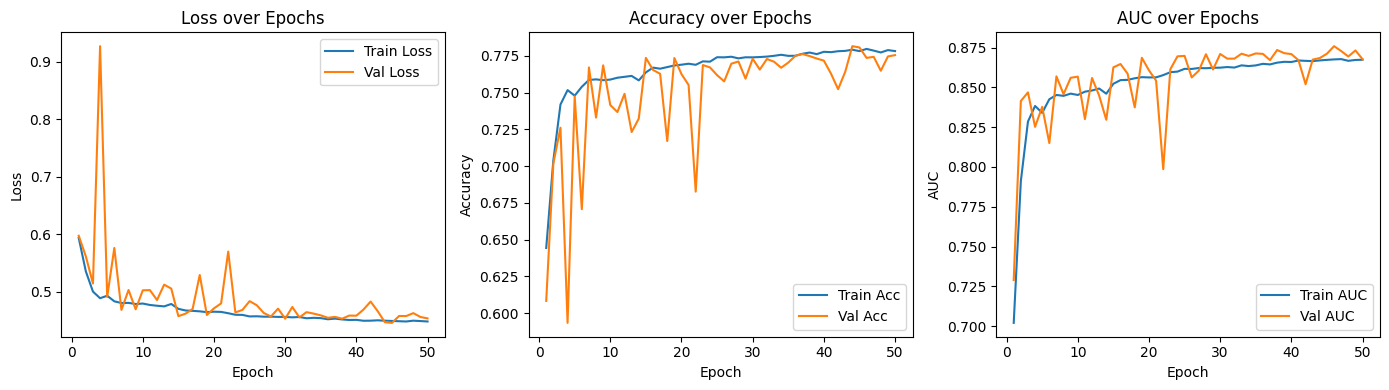

In [100]:
import matplotlib.pyplot as plt

# Retrieve metrics
history_dict = history.history
epochs = range(1, len(history_dict["loss"]) + 1)

# Plot Loss
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Train Loss")
plt.plot(epochs, history_dict["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["accuracy"], label="Train Acc")
plt.plot(epochs, history_dict["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["auc"], label="Train AUC")
plt.plot(epochs, history_dict["val_auc"], label="Val AUC")
plt.title("AUC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()
